In [2]:
import azureml.core
print(azureml.core.VERSION)

1.26.0


In [3]:

import logging

from matplotlib import pyplot as plt
import pandas as pd

import azureml.core
from azureml.core.experiment import Experiment
from azureml.core.workspace import Workspace
from azureml.core.dataset import Dataset
from azureml.train.automl import AutoMLConfig
from azureml.interpret import ExplanationClient

In [4]:
from azureml.core.experiment import Experiment

ws = Workspace.from_config()

In [5]:
from azureml.widgets import RunDetails
from azureml.core.run import Run

experiment = Experiment(ws, "TitanicExp")
#run_id = 'AutoML_fcd6f17a-6ef0-4518-ba20-7e5ad0d87e27' #replace with run_ID
#run = Run(experiment, run_id)
#RunDetails(run).show()

In [6]:
from azureml.train.automl.run import AutoMLRun
remote_run = AutoMLRun(experiment=experiment, run_id='AutoML_abac9517-7f1e-457b-afe7-ca47c29704bd')
remote_run

Experiment,Id,Type,Status,Details Page,Docs Page
TitanicExp,AutoML_abac9517-7f1e-457b-afe7-ca47c29704bd,automl,Completed,Link to Azure Machine Learning studio,Link to Documentation


In [7]:
best_run_customized, fitted_model_customized = remote_run.get_output()

Package:azureml-core, training version:1.27.0, current version:1.26.0
Package:azureml-dataprep, training version:2.14.2, current version:2.13.2
Package:azureml-dataprep-native, training version:33.0.0, current version:32.0.0
Package:azureml-dataprep-rslex, training version:1.12.1, current version:1.11.2
Package:azureml-dataset-runtime, training version:1.27.0, current version:1.26.0
Package:azureml-defaults, training version:1.27.0, current version:1.26.0
Package:azureml-interpret, training version:1.27.0, current version:1.26.0
Package:azureml-mlflow, training version:1.27.0, current version:1.26.0
Package:azureml-pipeline-core, training version:1.27.0, current version:1.26.0
Package:azureml-telemetry, training version:1.27.0, current version:1.26.0
Package:azureml-train-automl-client, training version:1.27.0, current version:1.26.0
Package:azureml-train-automl-runtime, training version:1.27.0.post1


In [8]:
# Wait for the best model explanation run to complete
from azureml.core.run import Run
model_explainability_run_id = remote_run.id + "_" + "ModelExplain"
print(model_explainability_run_id)
model_explainability_run = Run(experiment=experiment, run_id=model_explainability_run_id)
model_explainability_run.wait_for_completion()

# Get the best run object
best_run, fitted_model = remote_run.get_output()

AutoML_abac9517-7f1e-457b-afe7-ca47c29704bd_ModelExplain


Package:azureml-core, training version:1.27.0, current version:1.26.0
Package:azureml-dataprep, training version:2.14.2, current version:2.13.2
Package:azureml-dataprep-native, training version:33.0.0, current version:32.0.0
Package:azureml-dataprep-rslex, training version:1.12.1, current version:1.11.2
Package:azureml-dataset-runtime, training version:1.27.0, current version:1.26.0
Package:azureml-defaults, training version:1.27.0, current version:1.26.0
Package:azureml-interpret, training version:1.27.0, current version:1.26.0
Package:azureml-mlflow, training version:1.27.0, current version:1.26.0
Package:azureml-pipeline-core, training version:1.27.0, current version:1.26.0
Package:azureml-telemetry, training version:1.27.0, current version:1.26.0
Package:azureml-train-automl-client, training version:1.27.0, current version:1.26.0
Package:azureml-train-automl-runtime, training version:1.27.0.post1


In [9]:
best_run, fitted_model = remote_run.get_output()

Package:azureml-core, training version:1.27.0, current version:1.26.0
Package:azureml-dataprep, training version:2.14.2, current version:2.13.2
Package:azureml-dataprep-native, training version:33.0.0, current version:32.0.0
Package:azureml-dataprep-rslex, training version:1.12.1, current version:1.11.2
Package:azureml-dataset-runtime, training version:1.27.0, current version:1.26.0
Package:azureml-defaults, training version:1.27.0, current version:1.26.0
Package:azureml-interpret, training version:1.27.0, current version:1.26.0
Package:azureml-mlflow, training version:1.27.0, current version:1.26.0
Package:azureml-pipeline-core, training version:1.27.0, current version:1.26.0
Package:azureml-telemetry, training version:1.27.0, current version:1.26.0
Package:azureml-train-automl-client, training version:1.27.0, current version:1.26.0
Package:azureml-train-automl-runtime, training version:1.27.0.post1


In [10]:
model_name = best_run.properties['model_name']

script_file_name = 'inference/score.py'

best_run.download_file('outputs/scoring_file_v_1_0_0.py', 'inference/score.py')

In [11]:
model_name

'AutoMLabac951773'

In [12]:
description = 'AutoML Model trained on titanic data set to predict who survived'
tags = None
model = remote_run.register_model(model_name = model_name, description = description, tags = tags)

print(remote_run.model_id) # This will be written to the script file later in the notebook.

AutoMLabac951773


In [20]:
from azureml.core.model import InferenceConfig
from azureml.core.webservice import AciWebservice
from azureml.core.webservice import Webservice
from azureml.core.model import Model
from azureml.core.environment import Environment

inference_config = InferenceConfig(entry_script=script_file_name)

aciconfig = AciWebservice.deploy_configuration(cpu_cores = 1, 
                                               memory_gb = 1, 
                                               tags = {'area': "bmData", 'type': "automl_classification"}, 
                                               description = 'sample service for Automl Classification')

aci_service_name = 'automl-sample-bankmarketing-all'
print(aci_service_name)
aci_service = Model.deploy(ws, aci_service_name, [model], inference_config, aciconfig)
aci_service.wait_for_deployment(True)
print(aci_service.state)

automl-sample-bankmarketing-all
Tips: You can try get_logs(): https://aka.ms/debugimage#dockerlog or local deployment: https://aka.ms/debugimage#debug-locally to debug if deployment takes longer than 10 minutes.
Running
2021-05-07 12:44:10+00:00 Creating Container Registry if not exists.
2021-05-07 12:44:13+00:00 Use the existing image.
2021-05-07 12:44:13+00:00 Generating deployment configuration.
2021-05-07 12:44:14+00:00 Submitting deployment to compute..
2021-05-07 12:44:23+00:00 Checking the status of deployment automl-sample-bankmarketing-all..
2021-05-07 12:50:17+00:00 Checking the status of inference endpoint automl-sample-bankmarketing-all.
Succeeded
ACI service creation operation finished, operation "Succeeded"
Healthy


In [ ]:
#aci_service.get_logs()

In [14]:
test_data = "https://dprepdata.blob.core.windows.net/demo/Titanic.csv"
test_dataset = Dataset.Tabular.from_delimited_files(test_data)

In [15]:
# Load the bank marketing datasets.
from numpy import array

In [16]:
X_test = test_dataset.drop_columns(columns=['Survived'])
y_test = test_dataset.keep_columns(columns=['Survived'], validate=True)
test_dataset.take(5).to_pandas_dataframe()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,None,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,None,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,None,S


In [17]:
X_test = X_test.to_pandas_dataframe()
y_test = y_test.to_pandas_dataframe()

In [26]:
import json
import requests

X_test_json = X_test.to_json(orient='records')
data = "{\"data\": " + X_test_json +"}"
headers = {'Content-Type': 'application/json'}

resp = requests.post(aci_service.scoring_uri, data, headers=headers)

y_pred = json.loads(json.loads(resp.text))['result']

In [27]:
actual = array(y_test)
actual = actual[:,0]
print(len(y_pred), " ", len(actual))

891   891


<IPython.core.display.Javascript object>


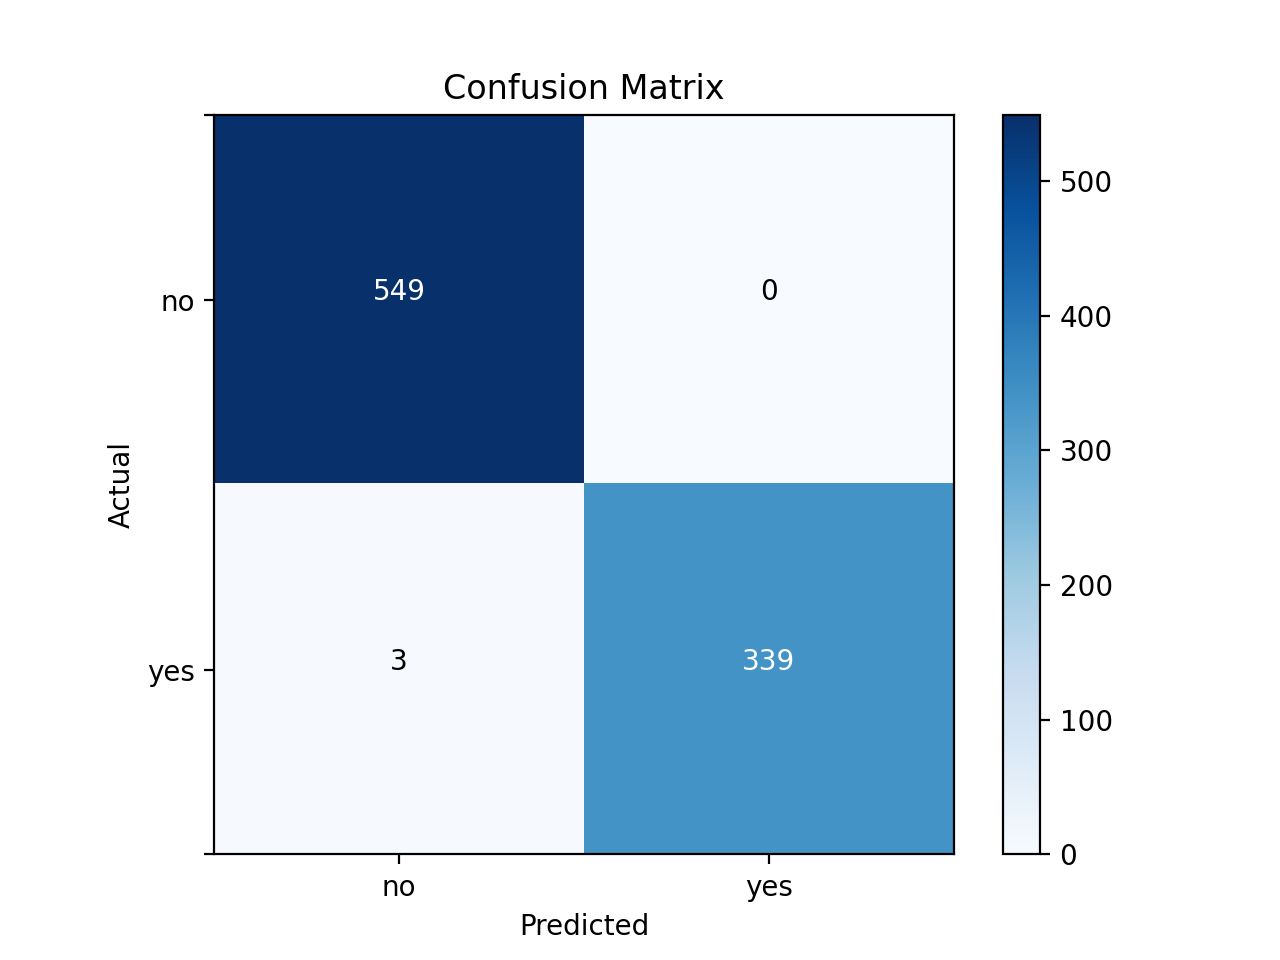

In [28]:
%matplotlib notebook
from sklearn.metrics import confusion_matrix
import numpy as np
import itertools

cf =confusion_matrix(actual,y_pred)
plt.imshow(cf,cmap=plt.cm.Blues,interpolation='nearest')
plt.colorbar()
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
class_labels = ['no','yes']
tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks,class_labels)
plt.yticks([-0.5,0,1,1.5],['','no','yes',''])
# plotting text value inside cells
thresh = cf.max() / 2.
for i,j in itertools.product(range(cf.shape[0]),range(cf.shape[1])):
    plt.text(j,i,format(cf[i,j],'d'),horizontalalignment='center',color='white' if cf[i,j] >thresh else 'black')
plt.show()

In [29]:
aci_service.delete()

In [24]:
from azureml.train.automl.model_proxy import ModelProxy

best_run1 = best_run.get_best_child()
# best_run = parent_run.get_best_child(metric = "accuracy")

best_model_proxy = ModelProxy(best_run1, compute_targer)

AttributeError: 'Run' object has no attribute 'get_best_child'

In [ ]:
#AutoMLabac951773

In [25]:
print(best_run.get_file_names())

['accuracy_table', 'automl_driver.py', 'azureml-logs/55_azureml-execution-tvmps_e2fc19d756bc4f387b369c325aa8419a77be2bb7f3ae2de09ce0ae3fa688ceb2_d.txt', 'azureml-logs/65_job_prep-tvmps_e2fc19d756bc4f387b369c325aa8419a77be2bb7f3ae2de09ce0ae3fa688ceb2_d.txt', 'azureml-logs/70_driver_log.txt', 'azureml-logs/75_job_post-tvmps_e2fc19d756bc4f387b369c325aa8419a77be2bb7f3ae2de09ce0ae3fa688ceb2_d.txt', 'azureml-logs/process_info.json', 'azureml-logs/process_status.json', 'confusion_matrix', 'explanation/9d316623/classes.interpret.json', 'explanation/9d316623/expected_values.interpret.json', 'explanation/9d316623/features.interpret.json', 'explanation/9d316623/global_names/0.interpret.json', 'explanation/9d316623/global_rank/0.interpret.json', 'explanation/9d316623/global_values/0.interpret.json', 'explanation/9d316623/local_importance_values_sparse.interpret.json', 'explanation/9d316623/per_class_names/0.interpret.json', 'explanation/9d316623/per_class_rank/0.interpret.json', 'explanation/9d316

In [26]:
from azureml.core.model import Model

# not used, just to see the registered model definition
registered_model_definition = Model(ws, 'AutoMLabac951773')
print(registered_model_definition)

Model(workspace=Workspace.create(name='mlopsdev', subscription_id='c46a9435-c957-4e6c-a0f4-b9a597984773', resource_group='mlops'), name=AutoMLabac951773, id=AutoMLabac951773:5, version=5, tags={}, properties={})


In [30]:
# Load the model into memory from downloaded file
import joblib

best_run.download_file('outputs/model.pkl')

#fitted_model = joblib.load('model.pkl')
#print(fitted_model)

In [21]:
# Load model from model registry in Workspace
from azureml.core.model import Model
import joblib
#import azureml.automl.runtime

model_path = Model.get_model_path('AutoMLabac951773', _workspace=ws)
fitted_model = joblib.load(model_path)
print(fitted_model)

ModuleNotFoundError: No module named 'azureml.automl.runtime'

In [39]:
# Get predictions from the model
y_predictions = fitted_model.predict(X_test) # x_test_df.head(1)
y_predictions # Should return a [0] or [1] depending on the prediction result

AttributeError: 'NoneType' object has no attribute 'predict'

In [ ]:
from azureml.train.automl.model_proxy import ModelProxy

best_run = parent_run.get_best_child()
# best_run = parent_run.get_best_child(metric = "accuracy")

best_model_proxy = ModelProxy(best_run, aml_remote_compute)

In [ ]:
y_test = test_dataset.keep_columns('target')
test_data_no_label = test_dataset.drop_columns('target')

test_data_no_label_df = test_data_no_label.to_pandas_dataframe()
print(test_data_no_label_df.shape)

In [ ]:
import time
start_time = time.time()
            
y_pred_test = best_model_proxy.predict(test_data_no_label)

print('Manual run timing: --- %s minutes needed for Predicting with ModelProxy ---' % ((time.time() - start_time)/60))

y_pred_test

In [ ]:
run_properties = json.loads(best_run.get_details()['properties']['pipeline_script'])
print(json.dumps(run_properties, indent = 1))